In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_9.h5
/kaggle/input/modelstacked-unet-with-style/full_style_epoch_12.h5
/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_16.h5
/kaggle/input/modelstacked-unet-with-style/full_style_epoch_15.h5
/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_11.h5
/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_15.h5
/kaggle/input/modelstacked-unet-with-style/full_style_epoch_10.h5
/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_12.h5
/kaggle/input/modelstacked-unet-with-style/epoch_results_file.csv
/kaggle/input/modelstacked-unet-with-style/step_results_file.csv
/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_14.h5
/kaggle/input/modelstacked-unet-with-style/full_style_epoch_9.h5
/kaggle/input/modelstacked-unet-with-style/full_style_epoch_16.h5
/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_10.h5
/kaggle/input/modelstacked-unet-with-style/full_style_epoch_14.h5
/kaggle/input/models

In [2]:
!pip install tensorflow==2.15.0
# !pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import os
import subprocess
import nibabel as nib
import tensorflow as tf
from skimage import exposure
from math import ceil
import matplotlib.pyplot as plt
import random

class DataLoader:
    def __init__(self, data_path, split_ratio, batch_size=None):
        self.data_path = data_path
        self.split_ratio = split_ratio
        self.all_subjects = None
        self.subjects_lists = []
        self.labels = {'train': 0, 'test': 1, 'validation': 2}
        self.size = [0, 0, 0]
        self.batch_size = batch_size
        self.slices_number = None

    def list_subjects(self):
        subjects = os.listdir(self.data_path)
        subjects = [item for item in subjects if item.startswith('sub')]
        subjects.reverse()
        self.all_subjects = subjects

    def get_nifti_path(self, subject, number_of_motion='1'):
        ref_path_stand = f'{self.data_path}/{subject}/anat/{subject}_acq-standard_T1w.nii'
#         select_path_stand = subprocess.run(['ls', ref_path_stand], capture_output=True, text=True).stdout.replace("\n", "")

        ref_path_motion = f'{self.data_path}/{subject}/anat/{subject}_acq-headmotion{number_of_motion}_T1w.nii'
#         select_path_motion = subprocess.run(['ls', ref_path_motion], capture_output=True, text=True).stdout.replace("\n", "")

        return [ref_path_stand , ref_path_motion ]

    def get_paired_volumes(self, path,remove_black=True):
        if os.path.exists(path[0]) and os.path.exists(path[1]):
            free_data = nib.load(path[0]).get_fdata()
            
            motion_data = nib.load(path[1]).get_fdata()
            if remove_black:
                free_data = exposure.rescale_intensity(free_data[37:-37], out_range=(-1.0, 1.0))
                motion_data = exposure.rescale_intensity(motion_data[37:-37], out_range=(-1.0, 1.0))
            else:
                free_data = exposure.rescale_intensity(free_data, out_range=(-1.0, 1.0))
                motion_data = exposure.rescale_intensity(motion_data, out_range=(-1.0, 1.0))
            return tf.convert_to_tensor(free_data), tf.convert_to_tensor(motion_data)
        else:
            return None, None

    def split_data(self):
        self.list_subjects()
        if ceil(sum(self.split_ratio)) == 1 and len(self.split_ratio) <= 3:
            self.split_ratio.insert(0, 0)
            cumulative_sum = [sum(self.split_ratio[:i + 1]) for i in range(len(self.split_ratio))]
            number_of_subjects = len(self.all_subjects)

            for i in range(1, len(self.split_ratio)):
                self.subjects_lists.append(
                    self.all_subjects[int(round(cumulative_sum[i - 1] * number_of_subjects)):int(
                        round(cumulative_sum[i] * number_of_subjects))])

                self.size[i - 1] = len(self.subjects_lists[i - 1])  * 2 * 190

                if i - 1 == 0:
                    self.size[i - 1] -= 8  * 2 * 190
        else:
            print("The Summation of ratios is not equal to 1")
       
    def generator(self, mode,remove_black=True):
        subjects = self.subjects_lists[self.labels[mode]]

        def data_gen():
            for subject in subjects:
                for i in range(2):
                    pathes = self.get_nifti_path(subject, str(i + 1))
                    free, motion = self.get_paired_volumes(pathes,remove_black)
                    if motion is not None:
                        self.slices_number = motion.shape[0]

                        for slice_id in range(0, self.slices_number):
                            start_idx = slice_id + 1
                            end_idx = (slice_id + 1) + 1
                            if (end_idx < self.slices_number-1):
                                free_slice = free[start_idx:end_idx]
                                free_slice = tf.transpose(free_slice, perm=[1, 2, 0])
                                
                                motion_slice = motion[start_idx:end_idx]
                                motion_slice = tf.transpose(motion_slice, perm=[1, 2, 0])
                                
                                motion_before_slice = motion[start_idx-1:end_idx-1]
                                motion_before_slice = tf.transpose(motion_before_slice, perm=[1, 2, 0])
                                
                                motion_after_slice = motion[start_idx+1:end_idx+1]
                                motion_after_slice = tf.transpose(motion_after_slice, perm=[1, 2, 0])

                                yield (
                                (motion_before_slice, motion_slice, motion_after_slice),
                                free_slice
                                )

        input_signature = (
            (tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
             tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
             tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32)),
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32)
        )

        dataset = tf.data.Dataset.from_generator(data_gen, output_signature=input_signature)
        dataset = dataset.batch(self.batch_size)

        return dataset

2024-06-20 09:14:19.335992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 09:14:19.336107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 09:14:19.469561: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
import math
import pandas as pd
from tensorflow.keras.models import model_from_json

# Constants
TRAIN = 1  # True False
TEST = 0  # True False
NB_EPOCH = 20
LEARNING_RATE = 0.001  # 0.001 (default)
HEIGHT, WIDTH = 256, 256
PREDICTION_PATH = '/kaggle/working/Prediction'
WEIGHTS_PATH = '/kaggle/working/Weights'

print('Reading Data ... ')
data_path = "/kaggle/input/mmmai-regist-data/MR-ART-Regist"
split_ratio = [0.7, 0.2, 0.1]
# split_ratio = [0.01, 0.98, 0.01]
batch_size = 5

data_loader = DataLoader(data_path, split_ratio, batch_size)
data_loader.split_data()

train_dataset = data_loader.generator('train')
test_dataset = data_loader.generator('test',False)
validation_dataset = data_loader.generator('validation')

Reading Data ... 


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
def ms_ssim_score(y_true, y_pred):
    score = tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, 2.0))
    return score
def ms_ssim_loss(y_true, y_pred):
    loss_ssim = 1.0 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, 2.0))
    return loss_ssim
def ssim_score(y_true, y_pred):
    score = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
    return score

def ssim_loss(y_true, y_pred):
    loss_ssim = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
    return loss_ssim
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))
def l2_loss(y_true, y_pred):
    """
    Computes the L2 loss between the ground truth and predicted tensors.

    Parameters:
        y_true (tf.Tensor): Ground truth tensor.
        y_pred (tf.Tensor): Predicted tensor.

    Returns:
        tf.Tensor: Normalized L2 loss.

    This function calculates the mean squared error (MSE) between the ground truth
    and predicted tensors. It then reduces the MSE along the spatial dimensions,
    typically representing the height and width of the tensors, resulting in a
    tensor of shape (batch_size,), where each element represents the mean MSE
    for a single sample in the batch.

    The loss is then normalized using L2 normalization to ensure that it falls
    within the range of 0 to 1. Finally, the mean of the normalized loss across
    the batch is computed and returned.
    """
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)

    # Reduce on spatial information
    batch_mse = tf.reduce_mean(mse, axis=(1, 2))

    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_mse, axis=-1)
    
    # Compute the mean of the normalized loss across the batch
    normalized_reduced_loss = tf.reduce_mean(batch_mse)

    return normalized_reduced_loss

def spatial_fft_loss(y_true, y_pred):
    """
    Custom loss function for spatial loss with FFT features.

    Args:
        y_true: Ground truth image(s).
        y_pred: Predicted image(s).

    Returns:
        Normalized reduced spatial loss.

    This function defines a custom loss for training neural networks. It applies a Fourier Transform
    to the true and predicted images, extracts the real and imaginary parts of the transformed
    features, and calculates the mean squared error between them. The loss is then normalized and
    reduced to a single scalar value.

    """
    # Apply Fourier Transform to the true and predicted images
    true_fft = tf.signal.fft2d(tf.cast(y_true, dtype=tf.complex64))
    pred_fft = tf.signal.fft2d(tf.cast(y_pred, dtype=tf.complex64))

    # Extract Real & Imaginary parts
    true_fft_real = tf.math.real(true_fft)
    true_fft_imag = tf.math.imag(true_fft)
    pred_fft_real = tf.math.real(pred_fft)
    pred_fft_imag = tf.math.imag(pred_fft)

    # Crop center rectangles for real and imag
    true_fft_real_cropped = crop_center_rectangle_mask(true_fft_real)
    true_fft_imag_cropped = crop_center_rectangle_mask(true_fft_imag)
    pred_fft_real_cropped = crop_center_rectangle_mask(pred_fft_real)
    pred_fft_imag_cropped = crop_center_rectangle_mask(pred_fft_imag)

    # Calculate L2 loss
    mse_real = tf.keras.losses.mean_squared_error(true_fft_real_cropped, pred_fft_real_cropped)
    mse_imag = tf.keras.losses.mean_squared_error(true_fft_imag_cropped, pred_fft_imag_cropped)

    # Total L2 loss
    total_loss = 0.5 * (mse_real + mse_imag)
    
    # Reduce on spatial information
    batch_loss = tf.reduce_mean(total_loss, axis=(1, 2))
    
    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_loss, axis=-1)

    normalized_reduced_loss = tf.reduce_mean(normalized_loss)

    return normalized_reduced_loss

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def init_vgg16_model(perceptual_layer_name='block3_conv3'):
    """
    Initialize a pre-trained VGG16 model for feature extraction.

    Args:
        perceptual_layer_name: Name of the layer to extract features from.

    Returns:
        Pre-trained VGG16 model with specified layer for feature extraction.

    This function loads a pre-trained VGG16 model with ImageNet weights and removes the top
    classification layers. It then extracts the specified layer for feature extraction and
    freezes the model's layers to prevent further training.

    """
    # Load pre-trained VGG16 model without the top classification layers
    vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

    # Extract the specified layer from the VGG16 model
    perceptual_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer(perceptual_layer_name).output)

    # Freeze the layers in the perceptual model so they are not trained further
    for layer in perceptual_model.layers:
        layer.trainable = False
        
    print("VGG16 Model Initialized")
    return perceptual_model

# Initialize VGG16 model for feature extraction
perceptual_model = init_vgg16_model()

def perceptual_fft_loss(y_true, y_pred):
    """
    Custom loss function for perceptual loss with FFT features.

    Args:
        y_true: Ground truth image(s).
        y_pred: Predicted image(s).

    Returns:
        Normalized reduced perceptual loss.

    This function defines a custom loss for training neural networks. It extracts features from
    true and predicted images using a pre-trained VGG16 model, applies a Fourier Transform to these
    features, and calculates the mean squared error between the real and imaginary parts of the
    transformed features. The loss is then normalized and reduced to a single scalar value.

    """
    # Convert single-channel images to RGB
    y_true_rgb = tf.repeat(y_true, 3, axis=-1)
    y_pred_rgb = tf.repeat(y_pred, 3, axis=-1)

    # Preprocess images for VGG16
    y_true_processed = tf.keras.applications.vgg16.preprocess_input(y_true_rgb)
    y_pred_processed = tf.keras.applications.vgg16.preprocess_input(y_pred_rgb)

    # Extract features from specified layer for true and predicted images
    features_true = perceptual_model(y_true_processed)
    features_pred = perceptual_model(y_pred_processed)

    # Apply Fourier Transform to the true and predicted images
    true_fft = tf.signal.fft2d(tf.cast(features_true, dtype=tf.complex64))
    pred_fft = tf.signal.fft2d(tf.cast(features_pred, dtype=tf.complex64))

    # Extract Real & Imaginary parts
    true_fft_real = tf.math.real(true_fft)
    true_fft_imag = tf.math.imag(true_fft)
    pred_fft_real = tf.math.real(pred_fft)
    pred_fft_imag = tf.math.imag(pred_fft)

    # Crop center rectangles for real and imag
    true_fft_real_cropped = crop_center_rectangle_mask(true_fft_real)
    true_fft_imag_cropped = crop_center_rectangle_mask(true_fft_imag)
    pred_fft_real_cropped = crop_center_rectangle_mask(pred_fft_real)
    pred_fft_imag_cropped = crop_center_rectangle_mask(pred_fft_imag)

    # Calculate L2 loss
    mse_real = tf.keras.losses.mean_squared_error(true_fft_real_cropped, pred_fft_real_cropped)
    mse_imag = tf.keras.losses.mean_squared_error(true_fft_imag_cropped, pred_fft_imag_cropped)

    # Total L2 loss
    total_loss = 0.5 * (mse_real + mse_imag)
    
    # Reduce on spatial information
    batch_loss = tf.reduce_mean(total_loss, axis=(1, 2))
    
    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_loss, axis=-1)

    normalized_reduced_loss = tf.reduce_mean(normalized_loss)

    return normalized_reduced_loss

def perceptual_loss(y_true, y_pred):
    """
    Custom loss function for perceptual loss.

    Args:
        y_true: Ground truth image(s).
        y_pred: Predicted image(s).

    Returns:
        Normalized reduced perceptual loss.

    This function defines a custom loss for training neural networks. It converts single-channel
    images to RGB, preprocesses them for VGG16, and extracts features from a specified layer
    using a pre-trained VGG16 model. It then calculates the mean squared error between the features
    of the true and predicted images. The loss is normalized and reduced to a single scalar value.

    """
    # Convert single-channel images to RGB
    y_true_rgb = tf.repeat(y_true, 3, axis=-1)
    y_pred_rgb = tf.repeat(y_pred, 3, axis=-1)

    # Preprocess images for VGG16
    y_true_processed = tf.keras.applications.vgg16.preprocess_input(y_true_rgb)
    y_pred_processed = tf.keras.applications.vgg16.preprocess_input(y_pred_rgb)

    # Extract features from specified layer for true and predicted images
    features_true = perceptual_model(y_true_processed)
    features_pred = perceptual_model(y_pred_processed)

    # Calculate L2 loss
    mse = tf.keras.losses.mean_squared_error(features_true, features_pred)

    # Reduce on spatial information
    batch_loss = tf.reduce_mean(mse, axis=(1, 2))
    
    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_loss, axis=-1)

    normalized_reduced_loss = tf.reduce_mean(normalized_loss)

    return normalized_reduced_loss

def psnr(y_true, y_pred):
    return tf.reduce_mean(-tf.image.psnr(y_true, y_pred, max_val=2.0))  # Adjust max_val for data normalized between -1 and 1

58889256/58889256 [==============================] - 0s 0us/step
VGG16 Model Initialized


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_metrics(dataset_path):
    """
    Plot training metrics from the CSV file.

    Args:
    dataset_path (str): Path to the directory containing the CSV file.
    """
    # Read the CSV file
#     data = pd.read_csv(f"{dataset_path}/Weights_Loss_Acc.csv")
    data = pd.read_csv(f'{dataset_path}/epoch_results_file (1).csv')
#     data_steps = pd.read_csv(f'{dataset_path}/step_results_file.csv')
    # Extract data for plotting
    epochs = data['Epoch']
    loss = data['Loss']
    val_loss = data['SSIM_Loss_val']
    l1_loss = data['L1_loss']
    val_l1_loss = data['L1_loss_val']
    mse = data['MSE']
    val_mse = data['MSE_val']
    psnr = data['PSNR']
    val_psnr = data['PSNR_val']
    ssim_score = data['SSIM_Score']
    val_ssim_score = data['SSIM_Score_val']
    
#     epoch_step = data_steps['epoch']
    # Plotting the metrics
 # Plotting the metrics
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.xticks(epochs[::1].astype(int))

    # MSE
    plt.subplot(2, 3, 2)
    plt.plot(epochs, mse, label='Training MSE')
    plt.plot(epochs, val_mse, label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.xticks(epochs[::1].astype(int))

    # PSNR
    plt.subplot(2, 3, 3)
    plt.plot(epochs, psnr, label='Training PSNR')
    plt.plot(epochs, val_psnr, label='Validation PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Training and Validation PSNR')
    plt.legend()
    plt.xticks(epochs[::1].astype(int))

    # SSIM
    plt.subplot(2, 3, 4)
    plt.plot(epochs, ssim_score, label='Training SSIM')
    plt.plot(epochs, val_ssim_score, label='Validation SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM Score')
    plt.title('Training and Validation SSIM Score')
    plt.legend()
    plt.xticks(epochs[::1].astype(int))
    
    plt.subplot(2, 3, 5)
    plt.plot(epochs, l1_loss, label='Training L1')
    plt.plot(epochs, val_l1_loss, label='Validation L1')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM Score')
    plt.title('Training and Validation SSIM Score')
    plt.legend()
    plt.xticks(epochs[::1].astype(int))
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics_plot.png')
    plt.show()
    def extract_float_from_string(tensor_str):
    # Adjust the slicing based on your actual string format
        try:
            # Assuming the format is something like 'tensor(..., shape=(), dtype=float32)'
            # Adjust the indices if the format is different
            numeric_str = tensor_str[10:20].strip()  # Extract the part you need
            return float(numeric_str)
        except:
            return None
    
#     steps = data_steps['Step']
#     Epoch = data_steps.groupby('Epoch')['Avg_SSIM_Loss'].mean().reset_index()['Epoch']
#     loss_step = data_steps.groupby('Epoch')['Avg_SSIM_Loss'].mean().reset_index()['Avg_SSIM_Loss']
# #     print(loss_step_ter)
# #     loss_step = data_steps['Avg_SSIM_Loss']
# #     print(float(data_steps['Avg_L1_loss'][2][10:20]))
#     data_steps['Avg_L1_loss'] = data_steps['Avg_L1_loss'].apply(extract_float_from_string)
#     L1_loss_step = data_steps.groupby('Epoch')['Avg_L1_loss'].mean().reset_index()['Avg_L1_loss']
#     ssim_score_step = data_steps.groupby('Epoch')['Avg_SSIM_Score'].mean().reset_index()['Avg_SSIM_Score']
#     psnr_step = data_steps.groupby('Epoch')['Avg_PSNR'].mean().reset_index()['Avg_PSNR']
    
    
#     plt.figure(figsize=(12, 6))

#     # Loss
#     plt.subplot(2, 2, 1)
#     plt.plot(Epoch, loss_step, label='Training Loss')
# #     plt.plot(epochs, val_loss, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training Loss')
#     plt.legend()
#     plt.xticks(Epoch.astype(int))

#     # MSE
#     plt.subplot(2, 2, 2)
#     plt.plot(Epoch, L1_loss_step, label='Training L1')
# #     plt.plot(epochs, val_mse, label='Validation MSE')
#     plt.xlabel('Epoch')
#     plt.ylabel('L1 loss')
#     plt.title('Training L1')
#     plt.legend()
#     plt.xticks(Epoch.astype(int))

#     # PSNR
#     plt.subplot(2, 2, 3)
#     plt.plot(Epoch, psnr_step, label='Training PSNR')
# #     plt.plot(epochs, val_psnr, label='Validation PSNR')
#     plt.xlabel('Epoch')
#     plt.ylabel('PSNR')
#     plt.title('Training PSNR')
#     plt.legend()
#     plt.xticks(Epoch.astype(int))

#     # SSIM
#     plt.subplot(2, 2, 4)
#     plt.plot(Epoch, ssim_score_step, label='Training SSIM')
# #     plt.plot(epochs, val_ssim_score, label='Validation SSIM')
#     plt.xlabel('Epoch')
#     plt.ylabel('SSIM Score')
#     plt.title('Training SSIM Score')
#     plt.legend()
#     plt.xticks(Epoch.astype(int))
    
#     plt.tight_layout()
#     plt.savefig('/kaggle/working/training_metrics_plot_steps.png')
#     plt.show()

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras import layers
def expand_moments_dim(moment):
    return tf.reshape(moment, [-1, 1, 1, tf.shape(moment)[-1]])
class AdaptiveInstanceNorm(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaptiveInstanceNorm, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, content, gamma, beta):
        c_mean, c_var = tf.nn.moments(content, axes=[1, 2], keepdims=True)
        c_std = tf.sqrt(c_var + self.epsilon)
        normalized = (content - c_mean) / c_std
        gamma = expand_moments_dim(gamma)
        beta = expand_moments_dim(beta)
#         print(normalized.shape)
        return multiply([gamma,normalized]) + beta

    def get_config(self):
        config = super(AdaptiveInstanceNorm, self).get_config()
        config.update({"epsilon": self.epsilon})
        return config

In [12]:
from tensorflow.keras.models import load_model
from scipy import ndimage
import os
import tensorflow.keras.backend as K

def load_and_sort_paths(dataset_path):
    """
    Load and sort paths from the given dataset path.

    Args:
    dataset_path (str): Path to the dataset.

    Returns:
    list: Sorted list of paths.
    """
    pathes = os.listdir(dataset_path)
    pathes.sort()
    pathes = pathes[1:]
    return pathes

def load_and_filter_volumes(dataset_path):
    """
    Load and filter volume names from the given dataset path.

    Args:
    dataset_path (str): Path to the dataset.

    Returns:
    list: List of filtered volume names.
    """
    volumes = os.listdir(dataset_path)
    volumes = [item for item in volumes if item.startswith('sub')]
    return volumes

def sample_reshape(sample):
    sample = sample.reshape(1,sample.shape[0],sample.shape[1],1)
    return sample

def plot_samples(volumes, model_path,style_model_path ,number_of_samples, norm=True):
    """
    Plot samples consisting of motion, free, and predicted images.

    Args:
    volumes (list): List of volume names.
    model_path (str): Path to the trained model.
    number_of_samples (int): Number of samples to plot.
    norm (bool, optional): Normalize the image intensities. Defaults to True.
    """
    angle = 90
    subs = np.random.randint(104, 134, number_of_samples)
    samples = np.random.randint(0, 118, number_of_samples)
#     subs = [110,112,113,133,121,122,107,109,119,128,130,121]
#     samples = [70,90,85,77,102,90,91,92,85,86,89,87]
    for i in range(number_of_samples):
        path = '/kaggle/input/mmmai-regist-data/MR-ART-Regist'
        ref_path_free = f'{path}/{volumes[subs[i]]}/anat/{volumes[subs[i]]}_acq-standard_T1w.nii'
#         select_path_free = subprocess.run(['ls', ref_path_free], capture_output=True, text=True).stdout.replace("\n", "")
        ref_path_motion = f'{path}/{volumes[subs[i]]}/anat/{volumes[subs[i]]}_acq-headmotion2_T1w.nii'
#         select_path_motion = subprocess.run(['ls', ref_path_motion], capture_output=True, text=True).stdout.replace("\n", "")
        if not os.path.exists(ref_path_motion):
            print(f"Ref path motion doesn't exist: {ref_path_motion}")
            continue
        motion_vol = nib.load(ref_path_motion).get_fdata()
        free_vol = nib.load(ref_path_free).get_fdata()
        free_vol = free_vol.astype(np.float32)
        motion_vol = motion_vol.astype(np.float32)
        
        model = load_model(model_path, custom_objects={'AdaptiveInstanceNorm':AdaptiveInstanceNorm,'ms_ssim_score':ms_ssim_score,'total_loss': total_loss,'ssim_loss':ssim_loss ,'ssim_score': ssim_score, 'psnr':psnr, 'K':K})
        style_model = load_model(style_model_path, custom_objects={'AdaptiveInstanceNorm':AdaptiveInstanceNorm,'ms_ssim_score':ms_ssim_score,'total_loss': total_loss,'ssim_loss':ssim_loss ,'ssim_score': ssim_score, 'psnr':psnr, 'K':K})
        if norm:
            motion_vol = exposure.rescale_intensity(motion_vol[37:-37], out_range=(0.0, 1.0))
            free_vol = exposure.rescale_intensity(free_vol, out_range=(0.0, 1.0))
        else:
            motion_vol = exposure.rescale_intensity(motion_vol[37:-37], out_range=(-1.0, 1.0))
            free_vol = exposure.rescale_intensity(free_vol[37:-37], out_range=(-1.0, 1.0))
        style_pred = style_model.predict(sample_reshape(free_vol[samples[i]]))
        
        pred_image = model.predict([sample_reshape(motion_vol[samples[i]-1]), sample_reshape(motion_vol[samples[i]]), sample_reshape(motion_vol[samples[i]+1]),style_pred])

        # Plot Images
        plt.figure(figsize=(8, 30),facecolor='black')
#         fig = plt.figure()

        # Plot Motion Image
        rotated_motion = ndimage.rotate(motion_vol[samples[i]], angle)
        plt.subplot(number_of_samples, 3, i * 3 + 1)
        plt.imshow(rotated_motion, cmap='gray')
        plt.title('Motion Image', color='white')
        plt.axis('off')

        # Plot Free Image
        rotated_free = ndimage.rotate(free_vol[samples[i]], angle)
        plt.subplot(number_of_samples, 3, i * 3 + 2)
        plt.imshow(rotated_free, cmap='gray')
        plt.title('Free Image', color='white')
        plt.axis('off')

        # Plot Model Image
        print(pred_image[0].shape)
        rotated_pred = ndimage.rotate(pred_image[0], angle)
        plt.subplot(number_of_samples, 3, i * 3 + 3)
        plt.imshow(rotated_pred, cmap='gray')
        plt.title('Model Image', color='white')
        plt.axis('off')
        
#         res = (rotated_motion-rotated_pred[0])
#         plt.subplot(number_of_samples, 4, i * 4 + 4)
#         plt.imshow(res, cmap='gray')
#         plt.title('Diff Image', color='white')
#         plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'sample_{i + 1}.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

    # Display the plot
    

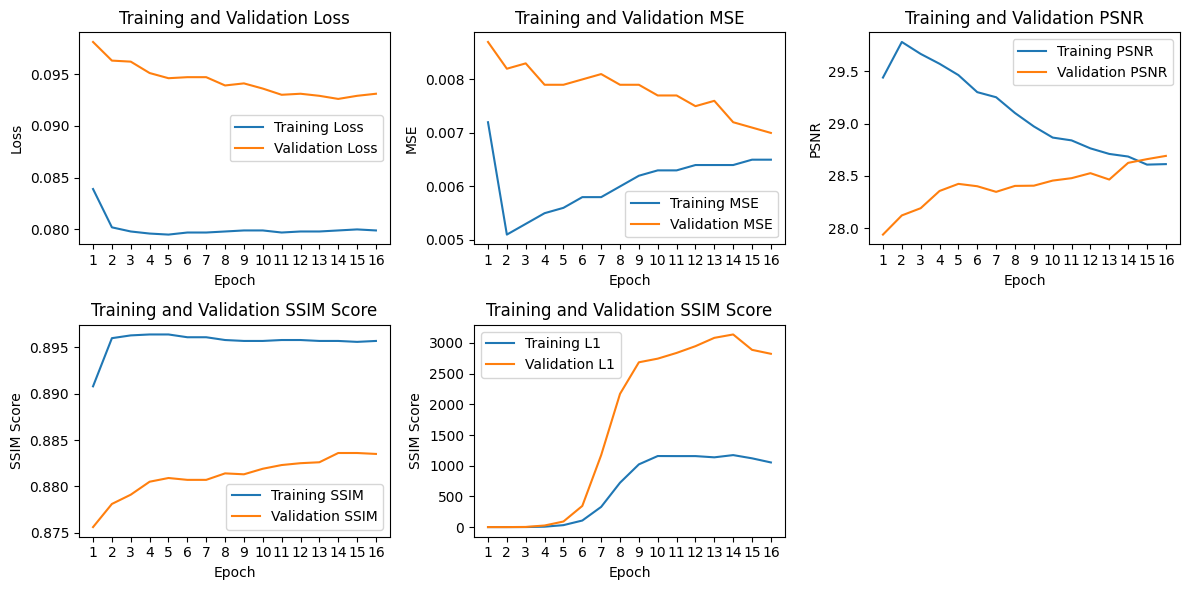

In [13]:
dataset_path = r"/kaggle/input/csv-data"
plot_training_metrics(dataset_path)

1/1 [==============================] - 4s 4s/step
(256, 256, 1)


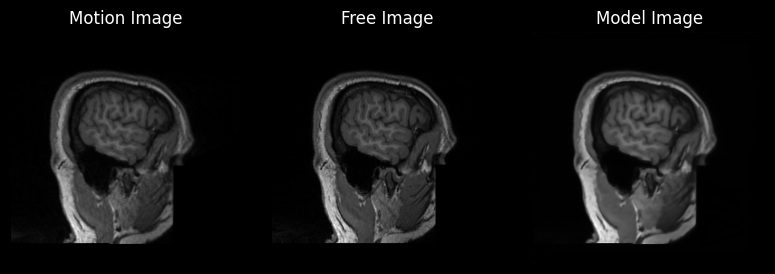

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


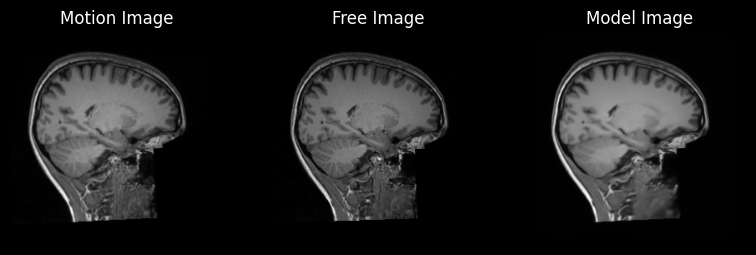

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


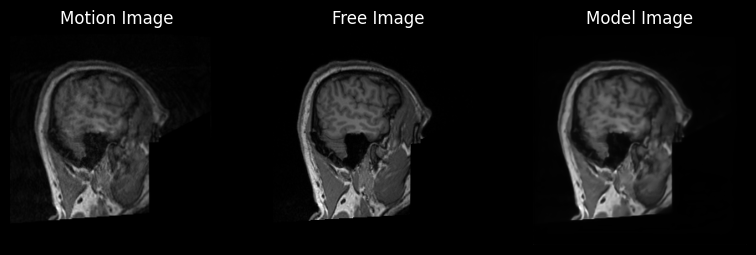

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


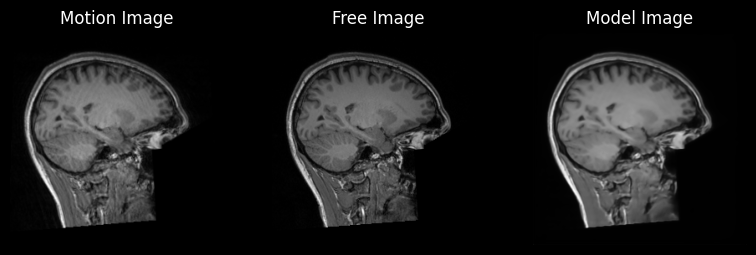

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


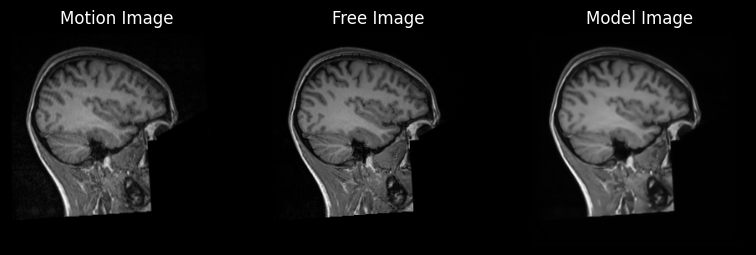

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


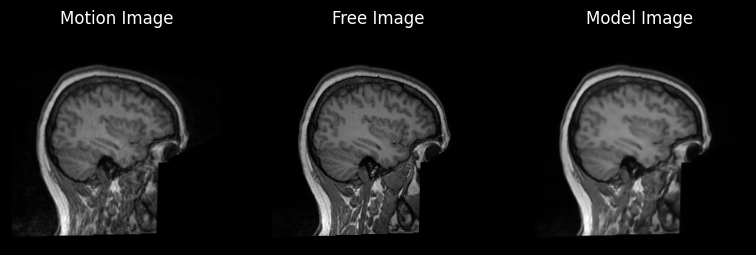

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


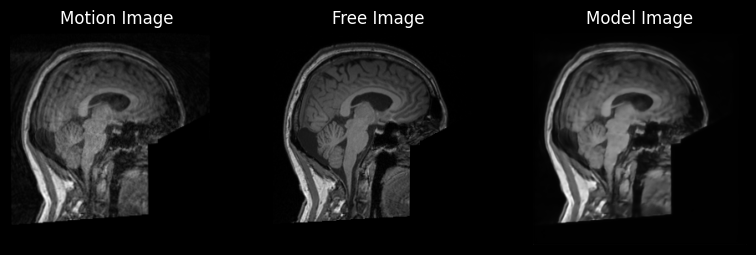

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


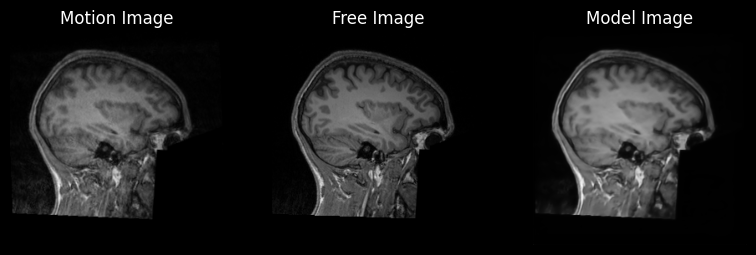

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


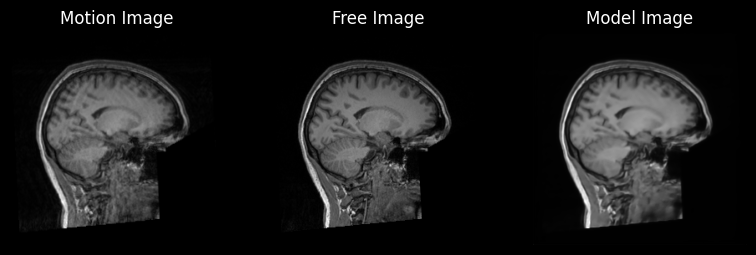

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


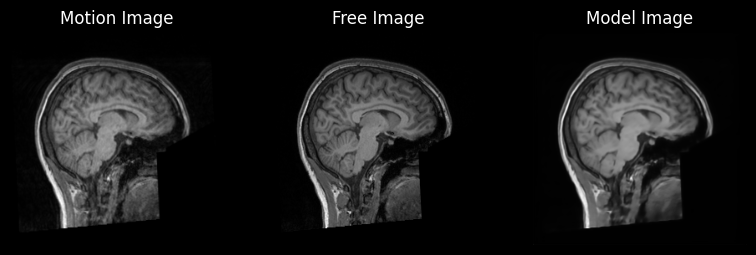

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


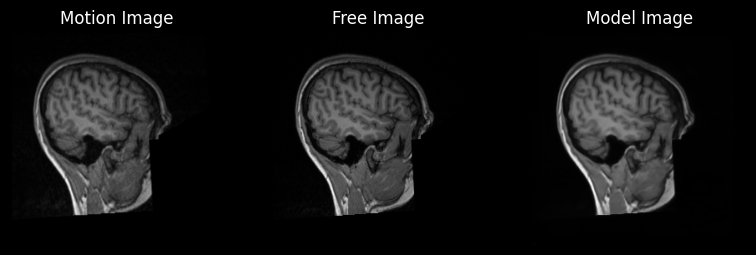

1/1 [==============================] - 3s 3s/step
(256, 256, 1)


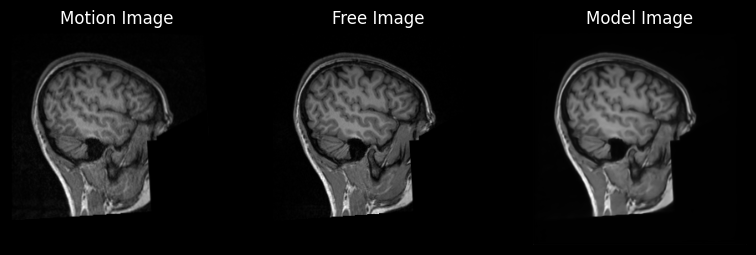

In [14]:
# Define Total Loss
def total_loss(y_true, y_pred):
    perceptual = perceptual_loss(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    
    scaled_perceptual = (perceptual*0.05807468295097351)
    adjusted_perceptual = (scaled_perceptual+0.009354699403047562)
    
    total = (ssim+adjusted_perceptual)/2
    return total
# Load and sort paths
pathes = load_and_sort_paths(dataset_path)
# Load and filter volumes
volumes = load_and_filter_volumes('/kaggle/input/mmmai-regist-data/MR-ART-Regist')
volumes.sort()

# Iterate over paths and plot samples
# for path in pathes:
#     print(f"Epoch: {path}")
plot_samples(volumes, "/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_16.h5","/kaggle/input/modelstacked-unet-with-style/full_style_epoch_16.h5", 12, norm=False)

In [15]:
def get_test(unet_path,style_path,dataset):
    unet_model = load_model(unet_path, custom_objects={'AdaptiveInstanceNorm':AdaptiveInstanceNorm,'ms_ssim_score':ms_ssim_score,'total_loss': total_loss,'ssim_loss':ssim_loss ,'ssim_score': ssim_score, 'psnr':psnr, 'K':K})
    style_model = load_model(style_path, custom_objects={'AdaptiveInstanceNorm':AdaptiveInstanceNorm,'ms_ssim_score':ms_ssim_score,'total_loss': total_loss,'ssim_loss':ssim_loss ,'ssim_score': ssim_score, 'psnr':psnr, 'K':K})
    print(f'Testing')
    ssim_scores, losses, l1_losses, pnsr_values, l2_losses = [], [], [], [], []        
    for step, ([Slice1, Slice2, Slice3], FreeImage) in enumerate(dataset):
            norm_list_output = style_model(Slice2, training=True)
            output1 = unet_model([Slice1, Slice2, Slice3, norm_list_output], training=True)
            ssim_scores.append(ssim_score(FreeImage, output1))
            loss_value = total_loss(FreeImage, output1)
            pnsr_values.append(psnr(FreeImage, output1))
            losses.append(loss_value)
            l2_losses.append(l2_loss(FreeImage, output1))
            recon_norm_list = style_model(output1)
            L1_loss_value = l1_loss(norm_list_output, recon_norm_list)
            l1_losses.append(L1_loss_value)
    print(f'Avg_Loss: {"{:.4f}".format(sum(losses)/len(losses))}, Avg_L1_loss: {sum(l1_losses)/len(l1_losses)}, Avg_SSIM_Score: {"{:.4f}".format(sum(ssim_scores)/len(ssim_scores))}, Avg_PSNR: {"{:.4f}".format(sum(pnsr_values)/len(pnsr_values))}, Avg_L2_Loss: {"{:.4f}".format(sum(l2_losses)/len(l2_losses))}')


In [16]:
get_test('/kaggle/input/modelstacked-unet-with-style/full_unet_epoch_16.h5','/kaggle/input/modelstacked-unet-with-style/full_style_epoch_16.h5',test_dataset)

Testing
Avg_Loss: 0.0691, Avg_L1_loss: 5570.95849609375, Avg_SSIM_Score: 0.8966, Avg_PSNR: -26.6270, Avg_L2_Loss: 0.0133
